# Observing a galaxy with MICADO in wide-field MCAO mode

In this example we will generate a basic galaxy object with the help of the ``ScopeSim_templates`` package.
We will then create a model of the ELT+MAORY+MICADO optical system using the ``MICADO`` package. 

In [1]:
%matplotlib inline
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

### Download the relevant scopesim instrument packages

We will need the ``MICADO_Sci`` package, as well as the support packages for ``Armazones``, the ``ELT``, and ``MAORY``. If you have not yet downloaded the packages, you can use the ``download_package`` command:

    sim.download_packages([
        "Armazones",
        "ELT",
        "MAORY",
        "MICADO",
    ])

### Set up on-sky source object

For ease of use we will use the helper function from ``ScopeSim_templates`` to create a two-layer spiral galaxy object.
The ``Source`` object contains two image layers (in ``<Source>.fields``) that each reference a unique spectrum.
The two layers correspond to the old and the new stellar populations of the galaxy.

In [2]:
gal = sim_tp.extragalactic.galaxies.spiral_two_component(extent=16*u.arcsec, fluxes=(15, 15)*u.mag)

https://scopesim.univie.ac.at/scopesim_templates/spiral_two_component.fits


Here we can see what is contained in the ``.fields`` and ``.spectra`` lists of the ``Source`` object

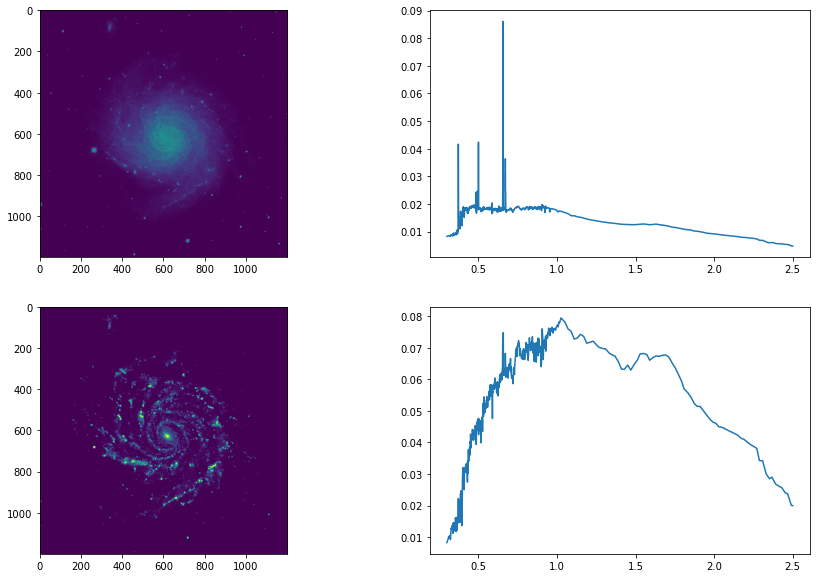

In [3]:
wave = np.linspace(0.3, 2.5, 2201) * u.um
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(gal.fields[0].data)
plt.subplot(222)
plt.plot(wave, gal.spectra[0](wave))
plt.subplot(223)
plt.imshow(gal.fields[1].data)
plt.subplot(224)
plt.plot(wave, gal.spectra[1](wave))

### Set up the MICADO system for MCAO 4mas H-band observations

The next step is to create a model of MICADO in memory. 
First we need to generate a set of commands that we can manipulate. 
Once we have these we can create a model of the optical system.

We use the ``UserCommands`` class and tell it to look for the ``MICADO`` package.
At the same time we set the observing modes to use. 
In this case we want ``MCAO`` and the 4mas per pixel wide-field optics (``IMG_4mas``)

In [4]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "IMG_4mas"])

We can update many of the observation parameters using the "!-bang" string syntax to access the values inside the hierarchical nested-dictionary structure of the ``UserCommands`` object.

Here we set the filter to the J-band, exposure length (DIT) to 60 seconds and number of exposures (DIT) to 1.
We can pass these parameters either as a dictionary using the ``.update(properties={...})`` method, or individually using normal dictionary notation with the "!-bang" strings.

In [5]:
cmd.update(properties={
    "!OBS.filter_name_fw1": "open",
    "!OBS.filter_name_fw2": "H", 
    "!OBS.ndit": 20, 
    "!OBS.dit": 3,

    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0)
})

cmd["!DET.width"] = 4096     # pixel
cmd["!DET.height"] = 4096

**Note: Filter Wheel names.** The contents of the filter wheels can be listed with ``micado["filter_wheel_1"].filters`` (or ``"filter_wheel_2"``) once the optical model has been created - see next cell.

Now that we have the commands set, we create the MICADO optical model

In [6]:
micado = sim.OpticalTrain(cmd)

Observing and reading out the detectors is also a simple operation

In [7]:
micado.observe(gal)
hdus = micado.readout()

INFO - emission not found in either '.meta' or '.table': [ELT]
INFO - emission not found in either '.meta' or '.table': [I00_EntrWin]
INFO - emission not found in either '.meta' or '.table': [I09_SCAO_PO]
INFO - emission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emissivity not found in either '.meta' or '.table': [I01_Fold1]
INFO - transmission not found in either '.meta' or '.table': [I01_Fold1]
INFO - emission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emissivity not found in either '.meta' or '.table': [I02_Coli1]
INFO - transmission not found in either '.meta' or '.table': [I02_Coli1]
INFO - emission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emissivity not found in either '.meta' or '.table': [I03_Coli2]
INFO - transmission not found in either '.meta' or '.table': [I03_Coli2]
INFO - emission not found in either '.meta' or '.table': [I04_Coli3]
INFO - emissivity not found in either '.meta' or '.table': [I04_Coli3]
INFO - transmiss

The output of a simulation is a list of ``fits.HDUList`` objects.
One ``HDUList`` for each detector plane.
In MICADO there is only 1 detector plane, but the class interface still requires that this single ``HDUList`` be placed in another list.

We can view the output of our custom Detecotr window like we would for any regular fits image in Python

Alternatively we could save the readout file to disk with the parameter ``filename=``:

    micado.readout(filename="my_galaxy.fits")

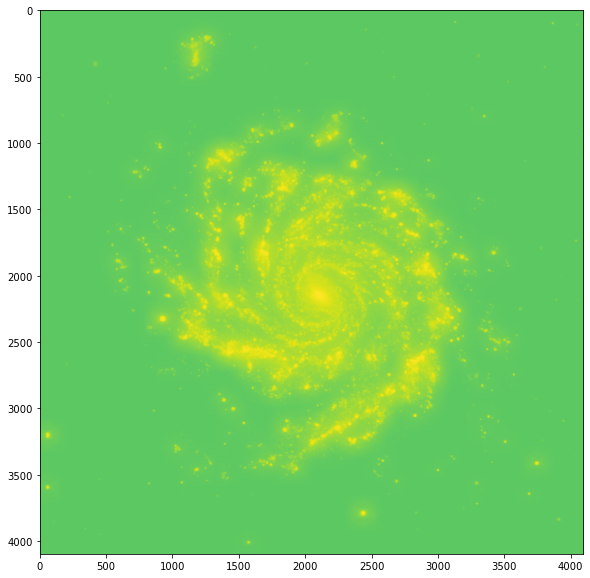

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(hdus[0][1].data, norm=LogNorm())